In [1]:
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split 
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from transformers import get_scheduler

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import zipfile

In [4]:
extract_to_path = '/kaggle/working/'
zip_file_path = '/kaggle/input/spooky-author-identification/train.zip'
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to_path)
zip_file_path = '/kaggle/input/spooky-author-identification/test.zip'
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to_path)

train_df = pd.read_csv('/kaggle/working/train.csv')
test_df = pd.read_csv('/kaggle/working/test.csv')
print('Number of rows in train dataset: ', train_df.shape[0])
print('Number of rows in test dataset: ', test_df.shape[0])

Number of rows in train dataset:  19579
Number of rows in test dataset:  8392


In [23]:
test_df

,text
0,"Still, as I urged our leaving Ireland with suc..."
1,"If a fire wanted fanning, it could readily be ..."
2,And when they had broken down the frail door t...
3,While I was thinking how I should possibly man...
4,I am not sure to what limit his knowledge may ...
...,...
8387,All this is now the fitter for my purpose.
8388,I fixed myself on a wide solitude.
8389,It is easily understood that what might improv...
8390,"Be this as it may, I now began to feel the ins..."


In [7]:
train_df = train_df.drop(columns=['id'])
test_df = test_df.drop(columns=['id'])

In [8]:
class TextAuthorDataset(Dataset):
    def __init__(self, df, tokenizer_name='bert-base-uncased', max_length=128):
        super().__init__()
        self.texts = df['text'].tolist()
        self.authors = df['author'].tolist()

        self.label_encoder = LabelEncoder()
        self.labels = self.label_encoder.fit_transform(self.authors)

        self.tokenizer = BertTokenizer.from_pretrained(tokenizer_name)
        self.max_length = max_length
        
    def __len__(self):
        return len(self.texts)
        
    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        encoding = self.tokenizer(
            text,
            max_length = self.max_length,
            padding = 'max_length',
            truncation = True,
            return_tensors = 'pt'
        )

        input_ids = encoding['input_ids'].squeeze(0)
        attention_mask = encoding['attention_mask'].squeeze(0)

        return{
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'label': torch.tensor(label, dtype=torch.long)
        }

In [9]:
train_df, valid_df = train_test_split(train_df, test_size=0.2, random_state=42, stratify=train_df['author'])
print(train_df.shape, valid_df.shape)

(15663, 2) (3916, 2)


In [10]:
train_dataset = TextAuthorDataset(train_df)
valid_dataset = TextAuthorDataset(valid_df)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [11]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32)

In [12]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [13]:
optimizer = AdamW(model.parameters(), lr=5e-5)

/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [14]:
num_training_steps = len(train_loader) * 3
lr_scheduler = get_scheduler('linear', optimizer=optimizer, num_warmup_steps=0, num_training_steps = num_training_steps)

In [15]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [16]:
for epoch in range(3):  # 3 epochs
        model.train()
        epoch_loss = 0
        for batch in tqdm(train_loader, desc=f'Training Epoch {epoch+1}'):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            lr_scheduler.step()

            epoch_loss += loss.item()
        print(f"Epoch {epoch + 1}: Loss = {loss.item()}")

Training Epoch 1: 100%|██████████| 490/490 [05:02<00:00,  1.62it/s]


Epoch 1: Loss = 0.26081329584121704


Training Epoch 2: 100%|██████████| 490/490 [05:07<00:00,  1.60it/s]


Epoch 2: Loss = 0.492878794670105


Training Epoch 3: 100%|██████████| 490/490 [05:06<00:00,  1.60it/s]

Epoch 3: Loss = 0.003865389619022608


In [18]:
model_save_path = '/kaggle/working/bert_text_author_model.pth'
torch.save(model.state_dict(), model_save_path)

In [19]:
model.eval()
correct = 0
total = 0
all_labels = []
all_preds = []

with torch.no_grad():
    for batch in tqdm(valid_loader, desc="Validating"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        predictions = torch.argmax(outputs.logits, dim=-1)
        
        correct += (predictions == labels).sum().item()
        total += labels.size(0)

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predictions.cpu().numpy())

print(f"Validation Accuracy: {correct / total:.2f}")

Validating: 100%|██████████| 123/123 [00:27<00:00,  4.48it/s]

Validation Accuracy: 0.89


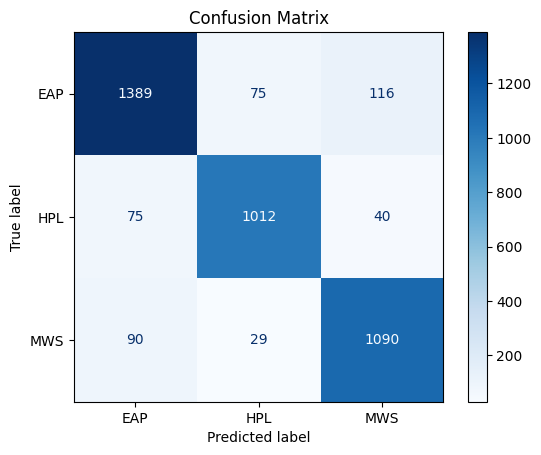

In [22]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=train_dataset.label_encoder.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

In [24]:
test_encodings = BertTokenizer.from_pretrained('bert-base-uncased').batch_encode_plus(
    test_df['text'].tolist(),
    max_length=128,
    padding='max_length',
    truncation=True,
    return_tensors='pt'
)

In [26]:
extract_to_path = '/kaggle/working/'
zip_file_path = '/kaggle/input/spooky-author-identification/sample_submission.zip'
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to_path)

In [27]:
submit_df = pd.read_csv('/kaggle/working/sample_submission.csv')
submit_df

,id,EAP,HPL,MWS
0,id02310,0.403494,0.287808,0.308698
1,id24541,0.403494,0.287808,0.308698
2,id00134,0.403494,0.287808,0.308698
3,id27757,0.403494,0.287808,0.308698
4,id04081,0.403494,0.287808,0.308698
...,...,...,...,...
8387,id11749,0.403494,0.287808,0.308698
8388,id10526,0.403494,0.287808,0.308698
8389,id13477,0.403494,0.287808,0.308698
8390,id13761,0.403494,0.287808,0.308698


In [33]:
model.eval()
with torch.no_grad():
    batch_size = 1
    probs = []
    for i in range(0, len(test_encodings['input_ids']), batch_size):
        input_ids = test_encodings['input_ids'][i:i+batch_size].to(device)
        attention_mask = test_encodings['attention_mask'][i:i+batch_size].to(device)
        
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        batch_probs = torch.softmax(outputs.logits, dim=-1).cpu().numpy()
        probs.append(batch_probs)
    probs = np.vstack(probs)

In [36]:
submit_df[['EAP','HPL','MWS']] = probs

In [39]:
submit_df.to_csv('submission-v1.csv', index=False)